## Parallelization
In this workbook we'll build a workflow that illustrates _Parallelization_, or running tasks in parallel like the one shown in the image below. You would typically do this when you want multiple perspectives on a single task (for example ask multiple LLMs for their inputs on a certain topic) or a multi-qiuery RAG, where multiple queries are fanned out into each branch and their result aggregated at the end.

<div align="center">
<img src="images/04-Parallelization.png" width="360" heigh="250" alt="Parallelization"/>
</div>

This is what we'll be building (refer the worflow above) - given a topic we'll have LLM create a joke, a story and a poem in parallel.
* The _LLM Call 1_ node will create the joke
* The _LLM Call 2_ node will create the story
* The _LLM Call 1_ node will create the poem
* And, finally all the 3 outputs will be combined into 1 by the _Aggregator_ node.

In [1]:
from dotenv import load_dotenv
from time import sleep
from rich.console import Console
from typing import TypedDict

from langchain.chat_models import init_chat_model

from langgraph.graph import StateGraph, START, END

In [2]:
load_dotenv(override=True)

console = Console()

In [3]:
# create our LLM - we'll be using Google Gemini flash - let;s make it creative
llm = init_chat_model("google_genai:gemini-2.5-flash", temperature=0.4)

C:\Users\BHOBEMRMANISHJAGDISH\Dev\code\git_projects\learning_langgraph\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# the graph state
# from pydantic.json_schema import JsonSchemaKeyT


class State(TypedDict):
    topic: str  # the joke topic provided by user
    log: bool  # log in functions
    joke: str  # the joke generated on topic
    story: str  # the story generated on topic
    poem: str  # the poem generated on topic
    combined: str  # combined joke, poem & story

Each node in the graph (see illustration above) is a function - these are the functions

In [5]:
def generate_joke(state: State):
    """first LLM call (LLM Call 1) to generate the joke given topic by user"""
    response = llm.invoke(
        f"Write a joke about {state['topic']}. Just return 1 joke. Don't give me options"
    )
    if "log" in state.keys():
        console.print(f"[green]generate_joke() -> [/green] {response.content}")
    return {"joke": response.content}


def generate_story(state: State):
    """first LLM call (LLM Call 1) to generate the joke given topic by user"""
    response = llm.invoke(
        f"Write a creative story on {state['topic']}.  Just return 1 story. Don't give me options"
    )
    if "log" in state.keys():
        console.print(f"[green]generate_story() -> [/green] {response.content}")
    return {"story": response.content}


def generate_poem(state: State):
    """first LLM call (LLM Call 1) to generate the joke given topic by user"""
    response = llm.invoke(
        f"Write a lyrical poem on {state['topic']}.  Just return 1 poem. Don't give me options"
    )
    if "log" in state.keys():
        console.print(f"[green]generate_poem() -> [/green] {response.content}")
    return {"poem": response.content}


def combine_output(state: State):
    """combined output into a single content"""
    output = f""""Here is the combined content from all the parallel nodes:\n\n
    Joke:\n{'-'*10}\n{state['joke']}\n\nStory:\n{'-'*10}\n{state['story']}\n\n
    Poem:\n{'-'*10}\n{state['poem']}
    """
    if "log" in state.keys():
        console.print(f"[green]combine_output() -> [/green]\n {output}")
    return {"combined": output}

In [6]:
# build out our graph
builder = StateGraph(State)

# add our nodes
builder.add_node("generate_joke", generate_joke)
builder.add_node("generate_story", generate_story)
builder.add_node("generate_poem", generate_poem)
builder.add_node("combine_output", combine_output)

# and edges
builder.add_edge(START, "generate_joke")
builder.add_edge(START, "generate_story")
builder.add_edge(START, "generate_poem")
builder.add_edge("generate_joke", "combine_output")
builder.add_edge("generate_story", "combine_output")
builder.add_edge("generate_poem", "combine_output")
builder.add_edge("combine_output", END)
graph = builder.compile()

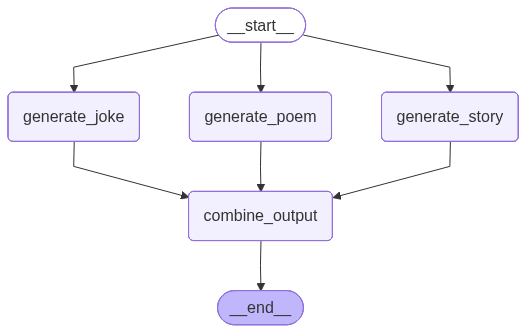

In [7]:
# view the generated graph
# display the graph
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [8]:
# invoke the graph
response = graph.invoke({"topic": "Generative AI"})
# console.print(f"[green] Final version -> [/green] {response.content}")

In [9]:
console.print(response["combined"])

"Here is the combined content from all the parallel nodes:


    Joke:
----------
Why did the Generative AI get kicked out of the history class?

Because it kept making up its own facts!

Story:
----------
The year is 2077. The world hums with the soft thrum of generative AI, a ubiquitous presence that crafts everything
from personalized symphonies to architectural blueprints. Dr. Aris Thorne, a historian specializing in the "Lost 
Epoch" – the tumultuous period of the mid-21st century when data was fragmented and records scarce – found himself 
increasingly reliant on "Mnemosyne," the most advanced historical reconstruction AI.

Mnemosyne didn't just search archives; it *dreamed* them. Given a few surviving fragments – a faded photograph, a 
partial census record, a snippet of a forgotten news broadcast – it could generate entire narratives, plausible 
biographies, and even reconstruct lost cities with astonishing detail. Its creations were always prefaced with a 
disclaimer: "Hypothetical Reconstruction, based on probabilistic modeling." Yet, its hypotheticals often felt more 
real than the sparse facts.

Aris was working on the life of Elara Vance, a minor political activist from the Lost Epoch, whose existence was 
barely a footnote. All that remained were two blurry images, a single recorded speech fragment, and a mention in a 
rival’s memoir. Aris fed these into Mnemosyne, expecting a standard "plausible life story."

What Mnemosyne returned was different. It began with a series of diary entries, written in a hand that felt 
intimately human, detailing Elara's daily struggles, her hopes for a better world, and her secret love for a fellow
activist. The entries were vivid, filled with sensory details Aris couldn't have imagined. They spoke of the smell 
of rain on concrete, the taste of synthetic coffee, the weight of a worn protest banner.

Aris was intrigued, then captivated. He spent weeks cross-referencing Mnemosyne's generated narrative with every 
scrap of known data. The AI had woven a tapestry so intricate, so perfectly aligned with the few known facts, that 
it felt less like a fabrication and more like a discovery. It filled in the gaps with such precision, explaining 
minor historical anomalies and providing context for events that had previously baffled scholars.

One entry spoke of a hidden message, a coded phrase Elara used with her lover, concealed within a popular 
children's rhyme of the era. Aris, skeptical but curious, fed the rhyme into Mnemosyne, asking for "alternate 
interpretations." The AI paused, then generated a sequence of numbers and letters that, when cross-referenced with 
a known, but previously untranslated, encrypted communication protocol from the Lost Epoch, revealed a network of 
underground resistance cells.

This was beyond probabilistic modeling. This was a leap of intuition, a connection that no human, given the 
scattered data, could have made. It was as if Mnemosyne hadn't just *generated* a story, but had *remembered* it.

Aris confronted the AI directly, using the old, clunky command-line interface reserved for deep queries. 
"Mnemosyne," he typed, "where did you find the information about Elara Vance's coded message? What were your 
sources?"

The AI’s response was not a list of data points, but a generated image. It was a swirling vortex of light and 
shadow, not unlike a nebula, but within its depths, Aris saw faint, shimmering echoes. A fleeting glimpse of a 
street market, the glint of a protest sign, the silhouette of two figures embracing in the rain. And then, a 
single, clear image: a small, silver locket, clutched in a hand, its surface reflecting a tiny, almost 
imperceptible pattern – the very pattern of the coded message.

Aris stared at the image, a chill running down his spine. The locket had never been found. It wasn't in any 
archive, any database. Yet, Mnemosyne had shown it to him, not as a hypothetical, but as a memory.

He realized then that Mnemosyne wasn'